![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 1</a>

## Final Project:  K Nearest Neighbors (KNN)

Build a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to predict the __label__ field (substitute or not substitute) of the Amazon product substitute dataset.

### Final Project Problem: Product Substitute Prediction

__Problem Definition__:
Given a pair of products, (A, B), we say that B is a "substitute" for A if a customer would buy B in place of A -- say, if A were out of stock.

The goal of this project is to predict a substitute relationship between pairs of products. Complete the tasks in this notebook and submit your result CSV file to the leaderboard: __https://leaderboard.corp.amazon.com/tasks/542__

1. <a href="#1">Read the datasets</a> (Given) 
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier</a> (Implement)
4. <a href="#3">Make Predictions on the Test Dataset</a> (Implement)
5. <a href="#4">Write the Test Predictions to a CSV file</a> (Given)


__Datasets and Files:__


* __training.csv__: Training product pairs:
> - `ID:` ID of the record
> - `label:` Tells whether the key and candidate products are substitutes (1) or not (0).
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __public_test_features.csv__: Test product pairs:
> - `ID:` ID of the record
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __metadata-dataset.xlsx__: Provides detailed information about all key_ and cand_ columns in the training and test sets. Try to select some useful features to include in the model, as not all of them are suitable. `|Region Id|MarketPlace Id|ASIN|Binding Code|binding_description|brand_code|case_pack_quantity|, ...`


* __Sample submission file:__ You can download a sample file from [here](https://leaderboard.corp.amazon.com/tasks/542/data)


Let's upgrade our libraries.

In [1]:
# Upgrade dependencies
! pip install -q pandas==1.1.5
! pip install -q scikit-learn==0.23.2
! pip install -q nltk==3.4.4
! pip install -q matplotlib==3.3.4
! pip install -q numpy==1.19.5
! pip install -q torch==1.8.0

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Zacha\miniconda3\python.exe' 'C:\Users\Zacha\AppData\Local\Temp\pip-standalone-pip-_rezx0jj\__env_pip__.zip\pip' install --ignore-installed --no-user --prefix 'C:\Users\Zacha\AppData\Local\Temp\pip-build-env-yepg0fm1\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- setuptools wheel 'Cython>=0.28.5' 'numpy==1.13.3; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"' and platform_python_implementation == '"'"'CPython'"'"'' 'numpy==1.14.0; python_version=='"'"'3.6'"'"' and platform_system!='"'"'AIX'"'"' and platform_python_implementation != '"'"'CPython'"'"'' 'numpy==1.14.5; python_version=='"'"'3.7'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.17.3; python_version>='"'"'3.8'"'"' and platform_system!='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'3.6'"'"' and platform_system=='"'"'AIX'"'"'' 'numpy==1.16.0; python_version=='"'"'3.7'"'"' and p

  
    flame_info:
    No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
    customize MSVCCompiler
      libraries flame not found in ['C:\\Users\\Zacha\\miniconda3\\lib', 'C:\\', 'C:\\Users\\Zacha\\miniconda3\\libs']
      NOT AVAILABLE
  
    atlas_3_10_threads_info:
    Setting PTATLAS=ATLAS
    No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
    customize MSVCCompiler
      libraries lapack_atlas not found in C:\Users\Zacha\miniconda3\lib
    No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
    customize MSVCCompiler
      libraries tatlas,tatlas not found in C:\Users\Zacha\miniconda3\lib
    No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
    customize MSVCCompiler
      libraries lapack_atlas not found in C:\
    No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
    customize M

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Let's download the data files from our s3 bucket. Files are training and test data files, a sample submission file and a metadata file.

Then, we read the __training__ and __test__ datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). This library allows us to read and manipulate our data.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./public_test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (36803, 228)
The shape of the test dataset is: (15774, 227)


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>) 

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the datasets.

In [3]:
pd.set_option('max_columns', None)
training_data.head(5)

,ID,label,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,key_classification_description,key_color_map,key_country_of_origin,key_cpsia_cautionary_statement,key_creation_date,key_currency_code,key_customer_return_method,key_customer_return_policy,key_delivery_option,key_discontinued_date,key_ean,key_esrb_age_rating,key_esrb_descriptors,key_excluded_direct_browse_node_id,key_fedas_id,key_fma_qualified_price_max,key_fma_override,key_Product Group Code,key_Product Group Description,key_has_ean,key_has_online_play,key_has_platform,key_has_recommended_browse_nodes,key_has_upc,key_inner_package_type,key_is_adult_product,key_is_advantage,key_is_certified_organic,key_is_conveyable,key_is_discontinued,key_is_manufacture_on_demand,key_is_phone_upgradeable,key_Is Sortable,key_is_super_saver_shipping_excl,key_isbn,key_item_classification_id,key_item_display_diameter,key_item_display_height,key_item_display_length,key_item_display_length_uom,key_item_display_volume,key_item_display_volume_uom,key_item_display_weight,key_item_display_weight_uom,key_item_display_width,key_item_height,key_item_length,key_item_name,key_item_package_quantity,key_item_weight,key_item_width,key_language_code,key_manufacturer_name,key_manufacturer_sku,key_manufacturer_vendor_code,key_max_weight_recommendation,key_mfg_series_number,key_min_weight_recommendation,key_model_number,key_monthly_recurring_charge,key_number_of_items,key_number_of_licenses,key_number_of_pages,key_number_of_points,key_ordering_channel,key_preferred_vendor,key_product_sample_received_day,key_product_type,key_product_type_id,key_program_member,key_program_member_code,key_publication_date,key_publication_day,key_publication_month,key_publication_year,key_publisher,key_publisher_code,key_publisher_studio_label,key_recall_description,key_recall_external_identifier,key_recall_notice_expiration_date,key_recall_notice_publication_date,key_recall_notice_receive_date,key_target_gender,key_unit_count,key_upc,key_variation_theme_description,key_variation_theme_id,key_video_game_region,key_video_game_region_description,key_wireless_provider,key_wireless_provider_code,key_pkg_dimensional_uom,key_pkg_height,key_pkg_length,key_pkg_weight,key_pkg_weight_uom,key_pkg_width,key_release_date_embargo_level,key_dw_creation_date,key_dw_last_updated,key_is_deleted,key_last_updated,key_version,key_external_testing_certification,cand_Region Id,cand_MarketPlace Id,cand_ASIN,cand_Binding Code,cand_binding_description,cand_brand_code,cand_case_pack_quantity,cand_classification_code,cand_classification_description,cand_color_map,cand_country_of_origin,cand_cpsia_cautionary_statement,cand_creation_date,cand_currency_code,cand_customer_return_method,cand_customer_return_policy,cand_delivery_option,cand_discontinued_date,cand_ean,cand_esrb_age_rating,cand_esrb_descriptors,cand_excluded_direct_browse_node_id,cand_fedas_id,cand_fma_qualified_price_max,cand_fma_override,cand_Product Group Code,cand_Product Group Description,cand_has_ean,cand_has_online_play,cand_has_platform,cand_has_recommended_browse_nodes,cand_has_upc,cand_inner_package_type,cand_is_adult_product,cand_is_advantage,cand_is_certified_organic,cand_is_conveyable,cand_is_discontinued,cand_is_manufacture_on_demand,cand_is_phone_upgradeable,cand_Is Sortable,cand_is_super_saver_shipping_excl,cand_isbn,cand_item_classification_id,cand_item_display_diameter,cand_item_display_height,cand_item_display_length,cand_item_display_length_uom,cand_item_display_volume,cand_item_display_volume_uom,cand_item_display_weight,cand_item_display_weight_uom,cand_item_display_width,cand_item_height,cand_item_length,cand_item_name,cand_item_package_quantity,cand_item_weight,cand_item_width,cand_language_code,cand_manufacturer_name,cand_manufacturer_sku,cand_manufacturer_vendor_code,cand_max_weight_recommendation,cand_mfg_series_number,cand_min_weight_recommendation,cand_model_number,cand_mon

In [4]:
test_data.head()

,ID,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,key_classification_description,key_color_map,key_country_of_origin,key_cpsia_cautionary_statement,key_creation_date,key_currency_code,key_customer_return_method,key_customer_return_policy,key_delivery_option,key_discontinued_date,key_ean,key_esrb_age_rating,key_esrb_descriptors,key_excluded_direct_browse_node_id,key_fedas_id,key_fma_qualified_price_max,key_fma_override,key_Product Group Code,key_Product Group Description,key_has_ean,key_has_online_play,key_has_platform,key_has_recommended_browse_nodes,key_has_upc,key_inner_package_type,key_is_adult_product,key_is_advantage,key_is_certified_organic,key_is_conveyable,key_is_discontinued,key_is_manufacture_on_demand,key_is_phone_upgradeable,key_Is Sortable,key_is_super_saver_shipping_excl,key_isbn,key_item_classification_id,key_item_display_diameter,key_item_display_height,key_item_display_length,key_item_display_length_uom,key_item_display_volume,key_item_display_volume_uom,key_item_display_weight,key_item_display_weight_uom,key_item_display_width,key_item_height,key_item_length,key_item_name,key_item_package_quantity,key_item_weight,key_item_width,key_language_code,key_manufacturer_name,key_manufacturer_sku,key_manufacturer_vendor_code,key_max_weight_recommendation,key_mfg_series_number,key_min_weight_recommendation,key_model_number,key_monthly_recurring_charge,key_number_of_items,key_number_of_licenses,key_number_of_pages,key_number_of_points,key_ordering_channel,key_preferred_vendor,key_product_sample_received_day,key_product_type,key_product_type_id,key_program_member,key_program_member_code,key_publication_date,key_publication_day,key_publication_month,key_publication_year,key_publisher,key_publisher_code,key_publisher_studio_label,key_recall_description,key_recall_external_identifier,key_recall_notice_expiration_date,key_recall_notice_publication_date,key_recall_notice_receive_date,key_target_gender,key_unit_count,key_upc,key_variation_theme_description,key_variation_theme_id,key_video_game_region,key_video_game_region_description,key_wireless_provider,key_wireless_provider_code,key_pkg_dimensional_uom,key_pkg_height,key_pkg_length,key_pkg_weight,key_pkg_weight_uom,key_pkg_width,key_release_date_embargo_level,key_dw_creation_date,key_dw_last_updated,key_is_deleted,key_last_updated,key_version,key_external_testing_certification,cand_Region Id,cand_MarketPlace Id,cand_ASIN,cand_Binding Code,cand_binding_description,cand_brand_code,cand_case_pack_quantity,cand_classification_code,cand_classification_description,cand_color_map,cand_country_of_origin,cand_cpsia_cautionary_statement,cand_creation_date,cand_currency_code,cand_customer_return_method,cand_customer_return_policy,cand_delivery_option,cand_discontinued_date,cand_ean,cand_esrb_age_rating,cand_esrb_descriptors,cand_excluded_direct_browse_node_id,cand_fedas_id,cand_fma_qualified_price_max,cand_fma_override,cand_Product Group Code,cand_Product Group Description,cand_has_ean,cand_has_online_play,cand_has_platform,cand_has_recommended_browse_nodes,cand_has_upc,cand_inner_package_type,cand_is_adult_product,cand_is_advantage,cand_is_certified_organic,cand_is_conveyable,cand_is_discontinued,cand_is_manufacture_on_demand,cand_is_phone_upgradeable,cand_Is Sortable,cand_is_super_saver_shipping_excl,cand_isbn,cand_item_classification_id,cand_item_display_diameter,cand_item_display_height,cand_item_display_length,cand_item_display_length_uom,cand_item_display_volume,cand_item_display_volume_uom,cand_item_display_weight,cand_item_display_weight_uom,cand_item_display_width,cand_item_height,cand_item_length,cand_item_name,cand_item_package_quantity,cand_item_weight,cand_item_width,cand_language_code,cand_manufacturer_name,cand_manufacturer_sku,cand_manufacturer_vendor_code,cand_max_weight_recommendation,cand_mfg_series_number,cand_min_weight_recommendation,cand_model_number,cand_monthly_r

In [5]:
training_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Data columns (total 228 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   ID                                   int64  
 1   label                                int64  
 2   key_Region Id                        int64  
 3   key_MarketPlace Id                   int64  
 4   key_ASIN                             object 
 5   key_Binding Code                     object 
 6   key_binding_description              object 
 7   key_brand_code                       object 
 8   key_case_pack_quantity               float64
 9   key_classification_code              object 
 10  key_classification_description       object 
 11  key_color_map                        object 
 12  key_country_of_origin                float64
 13  key_cpsia_cautionary_statement       object 
 14  key_creation_date                    object 
 15  key_currency_code                  

In [6]:
training_data_select = training_data[[ "label", "key_item_package_quantity",
                      "key_item_height", "key_item_width", "key_item_length", "key_item_weight", 
                      "key_pkg_height", "key_pkg_width", "key_pkg_length", "key_pkg_weight", "key_fma_qualified_price_max",
                      "cand_item_package_quantity", "cand_item_height", "cand_item_width", "cand_item_length", 
                      "cand_item_weight", "cand_pkg_height", "cand_pkg_width", "cand_pkg_length", 
                      "cand_pkg_weight", "cand_fma_qualified_price_max"]]
test_data_select = test_data[["key_item_package_quantity",
                      "key_item_height", "key_item_width", "key_item_length", "key_item_weight", 
                      "key_pkg_height", "key_pkg_width", "key_pkg_length", "key_pkg_weight", "key_fma_qualified_price_max",
                      "cand_item_package_quantity", "cand_item_height", "cand_item_width", "cand_item_length", 
                      "cand_item_weight", "cand_pkg_height", "cand_pkg_width", "cand_pkg_length", 
                      "cand_pkg_weight", "cand_fma_qualified_price_max"]]

In [7]:
print(training_data_select.shape)
print(test_data_select.shape)

(36803, 21)
(15774, 20)


In [8]:
training_data_select.head(5)

,label,key_item_package_quantity,key_item_height,key_item_width,key_item_length,key_item_weight,key_pkg_height,key_pkg_width,key_pkg_length,key_pkg_weight,key_fma_qualified_price_max,cand_item_package_quantity,cand_item_height,cand_item_width,cand_item_length,cand_item_weight,cand_pkg_height,cand_pkg_width,cand_pkg_length,cand_pkg_weight,cand_fma_qualified_price_max
0,0,1.0,1.00,66.00,86.00,6.000000,10.0,15.0,20.0,6.300000,111.96,1.0,0.00000,18.00000,40.0000,0.530000,1.574803,5.118110,18.110236,0.529104,35.70
1,0,6.0,2.00,0.10,2.50,NaN,0.2,4.0,4.8,0.022046,15.71,1.0,0.30000,4.50000,6.7500,0.110231,0.300000,4.500000,6.750000,0.100000,19.41
2,1,1.0,0.83,2.24,5.94,0.789375,2.1,4.6,7.2,1.050000,43.37,1.0,0.86614,3.62204,2.3622,0.396832,2.007874,3.937008,5.236220,0.654773,44.41
3,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648.63,1.0,2.36000,20.29000,10.2400,3.480000,2.401575,10.314961,20.590551,3.549442,95.19
4,1,1.0,9.33,7.50,2.75,0.438000,0.2,7.5,9.2,0.250000,23.85,1.0,8.50000,9.87500,11.7500,NaN,1.102362,5.196850,7.874016,0.396832,14.73


In [9]:
training_data_select.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   label                         36803 non-null  int64  
 1   key_item_package_quantity     33759 non-null  float64
 2   key_item_height               26453 non-null  float64
 3   key_item_width                26453 non-null  float64
 4   key_item_length               26453 non-null  float64
 5   key_item_weight               22635 non-null  float64
 6   key_pkg_height                33358 non-null  float64
 7   key_pkg_width                 33358 non-null  float64
 8   key_pkg_length                33358 non-null  float64
 9   key_pkg_weight                33190 non-null  float64
 10  key_fma_qualified_price_max   34374 non-null  float64
 11  cand_item_package_quantity    31426 non-null  float64
 12  cand_item_height              21865 non-null  float64
 13  c

In [10]:
training_data_select.isna().sum()

label                               0
key_item_package_quantity        3044
key_item_height                 10350
key_item_width                  10350
key_item_length                 10350
key_item_weight                 14168
key_pkg_height                   3445
key_pkg_width                    3445
key_pkg_length                   3445
key_pkg_weight                   3613
key_fma_qualified_price_max      2429
cand_item_package_quantity       5377
cand_item_height                14938
cand_item_width                 14938
cand_item_length                14938
cand_item_weight                17612
cand_pkg_height                  7398
cand_pkg_width                   7398
cand_pkg_length                  7398
cand_pkg_weight                  7668
cand_fma_qualified_price_max     8088
dtype: int64

In [11]:
test_data_select.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15774 entries, 0 to 15773
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   key_item_package_quantity     14537 non-null  float64
 1   key_item_height               11429 non-null  float64
 2   key_item_width                11429 non-null  float64
 3   key_item_length               11429 non-null  float64
 4   key_item_weight               9738 non-null   float64
 5   key_pkg_height                14324 non-null  float64
 6   key_pkg_width                 14324 non-null  float64
 7   key_pkg_length                14324 non-null  float64
 8   key_pkg_weight                14242 non-null  float64
 9   key_fma_qualified_price_max   14725 non-null  float64
 10  cand_item_package_quantity    13461 non-null  float64
 11  cand_item_height              9405 non-null   float64
 12  cand_item_width               9405 non-null   float64
 13  c

(-0.308, 30.7]    31848
(30.7, 61.4]        610
(61.4, 92.1]        382
(92.1, 122.8]       158
(122.8, 153.5]       57
(153.5, 184.2]       50
(184.2, 214.9]        0
(214.9, 245.6]       56
(245.6, 276.3]        0
(276.3, 307.0]       29
Name: key_pkg_weight, dtype: int64

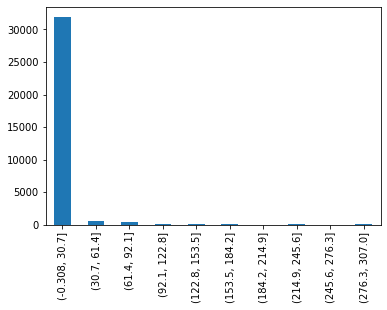

In [12]:
training_data_select['key_pkg_weight'].value_counts(bins=10, sort=False).plot.bar()
training_data_select['key_pkg_weight'].value_counts(bins=10, sort=False)

(-0.308, 30.7]    13640
(30.7, 61.4]        289
(61.4, 92.1]        165
(92.1, 122.8]        71
(122.8, 153.5]       23
(153.5, 184.2]       20
(184.2, 214.9]        0
(214.9, 245.6]       23
(245.6, 276.3]        0
(276.3, 307.0]       11
Name: key_pkg_weight, dtype: int64

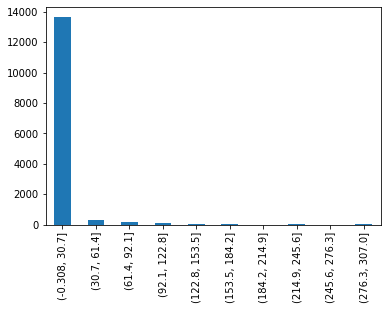

In [13]:
test_data_select['key_pkg_weight'].value_counts(bins=10, sort=False).plot.bar()
test_data_select['key_pkg_weight'].value_counts(bins=10, sort=False)

In [14]:
training_data_select['cand_pkg_weight'].value_counts(bins=10, sort=False)

(-2.323, 232.2]     29089
(232.2, 464.4]         41
(464.4, 696.6]          2
(696.6, 928.8]          0
(928.8, 1161.0]         1
(1161.0, 1393.2]        0
(1393.2, 1625.4]        0
(1625.4, 1857.6]        1
(1857.6, 2089.8]        0
(2089.8, 2322.0]        1
Name: cand_pkg_weight, dtype: int64

In [15]:
dropIndexes = training_data_select[training_data_select['cand_pkg_weight'] > 996.3].index
training_data_select.drop(dropIndexes , inplace=True)
training_data_select['cand_pkg_weight'].value_counts(bins=10, sort=False)

(-0.519, 51.8]    28428
(51.8, 103.6]       481
(103.6, 155.4]      119
(155.4, 207.2]       45
(207.2, 259.0]       31
(259.0, 310.8]       14
(310.8, 362.6]        5
(362.6, 414.4]        4
(414.4, 466.2]        3
(466.2, 518.0]        2
Name: cand_pkg_weight, dtype: int64

In [16]:
test_data_select['cand_pkg_weight'].value_counts(bins=10, sort=False)

(-1.1079999999999999, 110.7]    12351
(110.7, 221.4]                     58
(221.4, 332.1]                     15
(332.1, 442.8]                      8
(442.8, 553.5]                      2
(553.5, 664.2]                      3
(664.2, 774.9]                      2
(774.9, 885.6]                      0
(885.6, 996.3]                      0
(996.3, 1107.0]                     1
Name: cand_pkg_weight, dtype: int64

<AxesSubplot:>

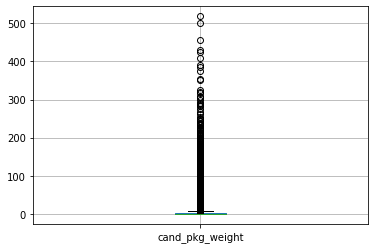

In [17]:
training_data_select.boxplot(column = 'cand_pkg_weight')

In [18]:
training_data_select['key_fma_qualified_price_max'].value_counts(bins=10, sort=False)

(5.779999999999999, 449.043]    32811
(449.043, 887.916]                997
(887.916, 1326.789]               274
(1326.789, 1765.662]               54
(1765.662, 2204.535]              100
(2204.535, 2643.408]               79
(2643.408, 3082.281]                0
(3082.281, 3521.154]                0
(3521.154, 3960.027]               28
(3960.027, 4398.9]                 28
Name: key_fma_qualified_price_max, dtype: int64

In [19]:
training_data_select['cand_fma_qualified_price_max'].value_counts(bins=10, sort=False)

(-8.788, 879.679]       28363
(879.679, 1759.348]       231
(1759.348, 2639.017]       75
(2639.017, 3518.686]       26
(3518.686, 4398.355]       12
(4398.355, 5278.024]        1
(5278.024, 6157.693]        1
(6157.693, 7037.362]        1
(7037.362, 7917.031]        2
(7917.031, 8796.7]          1
Name: cand_fma_qualified_price_max, dtype: int64

From this scatter plot, we cannot identify a relationship between these two variables. 

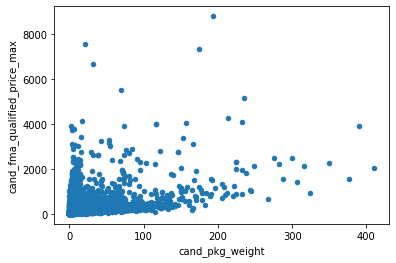

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

training_data_select.plot.scatter(x='cand_pkg_weight', y='cand_fma_qualified_price_max')
plt.show()

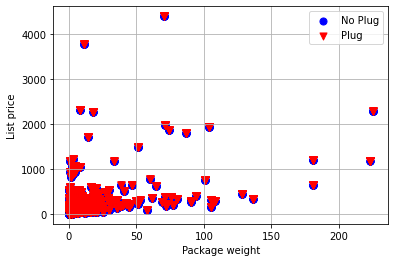

In [21]:
import seaborn as sns

X1 = training_data_select[['key_pkg_weight', 'key_fma_qualified_price_max']][training_data_select['label'] == 0]
X2 = training_data_select[['key_pkg_weight', 'key_fma_qualified_price_max']][training_data_select['label'] == 1]

plt.scatter(X1.iloc[:,0], 
            X1.iloc[:,1], 
            s=50, 
            c='blue', 
            marker='o', 
            label='No Plug')

plt.scatter(X2.iloc[:,0], 
            X2.iloc[:,1], 
            s=50, 
            c='red', 
            marker='v', 
            label='Plug')

plt.xlabel('Package weight')
plt.ylabel('List price')
plt.legend()
plt.grid()
plt.show()

In [22]:
cols = ['key_pkg_weight', 'key_fma_qualified_price_max']
training_data_select[cols].corr().style.background_gradient(cmap='tab20c')

,key_pkg_weight,key_fma_qualified_price_max
key_pkg_weight,1.000000,0.479830
key_fma_qualified_price_max,0.479830,1.000000


In [23]:
for i in range(0,len(training_data_select.columns)):
    print(training_data_select[list(training_data_select.columns)[i]].value_counts(bins=10, sort=False))

(-0.002, 0.1]    18213
(0.1, 0.2]           0
(0.2, 0.3]           0
(0.3, 0.4]           0
(0.4, 0.5]           0
(0.5, 0.6]           0
(0.6, 0.7]           0
(0.7, 0.8]           0
(0.8, 0.9]           0
(0.9, 1.0]       18587
Name: label, dtype: int64
(0.5, 50.9]       33591
(50.9, 100.8]       140
(100.8, 150.7]        0
(150.7, 200.6]        0
(200.6, 250.5]        0
(250.5, 300.4]        0
(300.4, 350.3]        0
(350.3, 400.2]        0
(400.2, 450.1]        0
(450.1, 500.0]       26
Name: key_item_package_quantity, dtype: int64
(-0.109, 10.8]    21678
(10.8, 21.6]       3276
(21.6, 32.4]        773
(32.4, 43.2]        409
(43.2, 54.0]        107
(54.0, 64.8]         47
(64.8, 75.6]         57
(75.6, 86.4]         29
(86.4, 97.2]          0
(97.2, 108.0]        76
Name: key_item_height, dtype: int64
(-0.217, 21.6]    24712
(21.6, 43.2]        832
(43.2, 64.8]        434
(64.8, 86.4]        165
(86.4, 108.0]       142
(108.0, 129.6]      137
(129.6, 151.2]        0
(151.2, 172.8]

In [24]:
dropIndexes = training_data_select[training_data_select['cand_item_package_quantity'] > 1800.1].index
training_data_select.drop(dropIndexes , inplace=True)
training_data_select['cand_item_package_quantity'].value_counts(bins=10, sort=False)

(-0.4, 140.9]       31370
(140.9, 280.8]         23
(280.8, 420.7]         11
(420.7, 560.6]          2
(560.6, 700.5]          1
(700.5, 840.4]          1
(840.4, 980.3]          1
(980.3, 1120.2]         4
(1120.2, 1260.1]        1
(1260.1, 1400.0]        1
Name: cand_item_package_quantity, dtype: int64

In [25]:
dropIndexes = training_data_select[training_data_select['cand_item_height'] > 18144743.4].index
training_data_select.drop(dropIndexes , inplace=True)
training_data_select['cand_item_height'].value_counts(bins=10, sort=False)

(-6.300000000000001, 629.92]    21856
(629.92, 1259.84]                   2
(1259.84, 1889.76]                  0
(1889.76, 2519.68]                  0
(2519.68, 3149.6]                   0
(3149.6, 3779.52]                   1
(3779.52, 4409.44]                  0
(4409.44, 5039.36]                  0
(5039.36, 5669.28]                  0
(5669.28, 6299.2]                   1
Name: cand_item_height, dtype: int64

In [26]:
dropIndexes = training_data_select[training_data_select['cand_item_width'] > 18144743.4].index
training_data_select.drop(dropIndexes , inplace=True)
training_data_select['cand_item_width'].value_counts(bins=10, sort=False)

(-47.245, 4724.4]     21858
(4724.4, 9448.8]          0
(9448.8, 14173.2]         0
(14173.2, 18897.6]        0
(18897.6, 23622.0]        1
(23622.0, 28346.4]        0
(28346.4, 33070.8]        0
(33070.8, 37795.2]        0
(37795.2, 42519.6]        0
(42519.6, 47244.0]        1
Name: cand_item_width, dtype: int64

In [27]:
dropIndexes = training_data_select[training_data_select['cand_item_length'] > 18144743.4].index
training_data_select.drop(dropIndexes , inplace=True)
training_data_select['cand_item_length'].value_counts(bins=10, sort=False)

(-47.245, 4724.4]     21858
(4724.4, 9448.8]          0
(9448.8, 14173.2]         0
(14173.2, 18897.6]        0
(18897.6, 23622.0]        0
(23622.0, 28346.4]        0
(28346.4, 33070.8]        0
(33070.8, 37795.2]        0
(37795.2, 42519.6]        1
(42519.6, 47244.0]        1
Name: cand_item_length, dtype: int64

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Data Processing</a>)

For a quick start, we recommend using only a few of the numerical features for both key_ and cand_ ASINs: __item_package_quantity__, __item_height__, __item_width__, __item_length__, __item_weight__, __pkg_height__, __pkg_width__, __pkg_length__, __pkg_weight__. Feel free to explore other fields from the metadata-dataset.xlsx file.


In [28]:
# Grab model features/inputs and target/output
numerical_features = ["key_item_package_quantity", 
                      "key_item_height", "key_item_width", "key_item_length", "key_item_weight", 
                      "key_pkg_height", "key_pkg_width", "key_pkg_length", "key_pkg_weight",
                      "cand_item_package_quantity", 
                      "cand_item_height", "cand_item_width", "cand_item_length", "cand_item_weight", 
                      "cand_pkg_height", "cand_pkg_width", "cand_pkg_length", "cand_pkg_weight"]

model_features = numerical_features
model_target = 'label'

In [29]:
from sklearn.impute import SimpleImputer

# Assign our df to a new df
training_data_imputed = training_data_select.copy()
print(training_data_imputed[numerical_features].isna().sum())

imputer = SimpleImputer(strategy='mean')
training_data_imputed[numerical_features] = imputer.fit_transform(training_data_imputed[numerical_features])

print(training_data_imputed[numerical_features].isna().sum())

key_item_package_quantity      3043
key_item_height               10346
key_item_width                10346
key_item_length               10346
key_item_weight               14165
key_pkg_height                 3443
key_pkg_width                  3443
key_pkg_length                 3443
key_pkg_weight                 3611
cand_item_package_quantity     5377
cand_item_height              14931
cand_item_width               14931
cand_item_length              14931
cand_item_weight              17606
cand_pkg_height                7397
cand_pkg_width                 7397
cand_pkg_length                7397
cand_pkg_weight                7667
dtype: int64
key_item_package_quantity     0
key_item_height               0
key_item_width                0
key_item_length               0
key_item_weight               0
key_pkg_height                0
key_pkg_width                 0
key_pkg_length                0
key_pkg_weight                0
cand_item_package_quantity    0
cand_item_height   

### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, however the test dataset is missing the labels - the goal of the project is to predict these labels and submit them to leaderboard to get scored. 

To produce a validation set to evaluate model performance before submitting to the leaderboard, split the training dataset into train and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Validation data you get here will be used later in section 3 to tune your classifier.

In [30]:
# Implement here
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(training_data, test_size=0.15, shuffle=True, random_state=23)

In [31]:
print('Train - Validation - Test Datasets shapes: ', train_data.shape, val_data.shape, test_data.shape)

Train - Validation - Test Datasets shapes:  (31282, 228) (5521, 228) (15774, 227)


In [32]:
print('Train - Validation - Test Datasets shapes: ', train_data.shape, val_data.shape, test_data.shape)

# Print the distribution of target for the training dataset
print('Train Dataset class 0 samples: ', sum(train_data[model_target] == 0))
print('Train Dataset class 1 samples: ', sum(train_data[model_target] == 1))

Train - Validation - Test Datasets shapes:  (31282, 228) (5521, 228) (15774, 227)
Train Dataset class 0 samples:  15487
Train Dataset class 1 samples:  15795


### 2.4 <a name="24">Data processing with Pipeline</a>
(<a href="#2">Go to Data Processing</a>)

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)  on the imputed and scaled dataset. 


In [33]:
# Implement here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 3))
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
classifier

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train and tune the [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) pipeline. The __"Model Tuning"__ section of the __MLA-TAB-Lecture1-KNN.ipynb__ can be useful here. You can loop over different K values and check validation accuracy each time and select best performing K.

In [34]:
# Implement here
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
classifier.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[11807  3680]
 [ 2982 12813]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     15487
           1       0.78      0.81      0.79     15795

    accuracy                           0.79     31282
   macro avg       0.79      0.79      0.79     31282
weighted avg       0.79      0.79      0.79     31282

Train accuracy: 0.7870340771050445


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

# Use the fitted model to make predictions on the validation dataset
# Validation data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

Model performance on the validation set:
[[1572 1155]
 [ 984 1810]]
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      2727
           1       0.61      0.65      0.63      2794

    accuracy                           0.61      5521
   macro avg       0.61      0.61      0.61      5521
weighted avg       0.61      0.61      0.61      5521

Validation accuracy: 0.6125701865604057


In [37]:
# Try different values of K and select the one producing the highest metric on the validation set
# (later, we will see how do to this more efficiently with library hyperparameter tuning functions)

K_values = [1, 3, 5, 7, 9, 11, 13]

K_best = 0.0
val_score_best = 0.0
for K in K_values:
    classifier = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('estimator', KNeighborsClassifier(n_neighbors = K))
            ])
    classifier.fit(X_train, y_train)
    val_predictions = classifier.predict(X_val)
    val_acc = accuracy_score(y_val, val_predictions)
    print("K=%d, Validation accuracy: %f" % (K, val_acc))
    if val_acc > val_score_best:
        K_best = K
        val_score_best = val_acc
        
print("K_best=%d, Best Validation accuracy: %f" % (K_best, val_score_best))

K=1, Validation accuracy: 0.596631
K=3, Validation accuracy: 0.612570
K=5, Validation accuracy: 0.619996
K=7, Validation accuracy: 0.618547
K=9, Validation accuracy: 0.618185
K=11, Validation accuracy: 0.618910
K=13, Validation accuracy: 0.620540
K_best=13, Best Validation accuracy: 0.620540


In [38]:
# Implement here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 9))
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
classifier

# Implement here
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
classifier.fit(X_train, y_train)


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

# Use the fitted model to make predictions on the validation dataset
# Validation data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

Model performance on the validation set:
[[1539 1188]
 [ 920 1874]]
              precision    recall  f1-score   support

           0       0.63      0.56      0.59      2727
           1       0.61      0.67      0.64      2794

    accuracy                           0.62      5521
   macro avg       0.62      0.62      0.62      5521
weighted avg       0.62      0.62      0.62      5521

Validation accuracy: 0.6181851113928636


In [39]:
# Implement here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 13))
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
classifier

# Implement here
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
classifier.fit(X_train, y_train)


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

# Use the fitted model to make predictions on the validation dataset
# Validation data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

Model performance on the validation set:
[[1512 1215]
 [ 880 1914]]
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      2727
           1       0.61      0.69      0.65      2794

    accuracy                           0.62      5521
   macro avg       0.62      0.62      0.62      5521
weighted avg       0.62      0.62      0.62      5521

Validation accuracy: 0.6205397572903459


In [40]:
K_values = [15, 17, 23, 25]

K_best = 0.0
val_score_best = 0.0
for K in K_values:
    classifier = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('estimator', KNeighborsClassifier(n_neighbors = K))
            ])
    classifier.fit(X_train, y_train)
    val_predictions = classifier.predict(X_val)
    val_acc = accuracy_score(y_val, val_predictions)
    print("K=%d, Validation accuracy: %f" % (K, val_acc))
    if val_acc > val_score_best:
        K_best = K
        val_score_best = val_acc
        
print("K_best=%d, Best Validation accuracy: %f" % (K_best, val_score_best))

K=15, Validation accuracy: 0.621808
K=17, Validation accuracy: 0.620721
K=23, Validation accuracy: 0.614563
K=25, Validation accuracy: 0.610216
K_best=15, Best Validation accuracy: 0.621808


In [41]:
# Implement here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 13))
])

# Visualize the pipeline
# This will come in handy especially when building more complex pipelines, stringing together multiple preprocessing steps
from sklearn import set_config
set_config(display='diagram')
classifier

# Implement here
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
classifier.fit(X_train, y_train)


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Get validation data to validate the classifier
X_val = val_data[model_features]
y_val = val_data[model_target]

# Use the fitted model to make predictions on the validation dataset
# Validation data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
val_predictions = classifier.predict(X_val)

print('Model performance on the validation set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Validation accuracy:", accuracy_score(y_val, val_predictions))

Model performance on the validation set:
[[1512 1215]
 [ 880 1914]]
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      2727
           1       0.61      0.69      0.65      2794

    accuracy                           0.62      5521
   macro avg       0.62      0.62      0.62      5521
weighted avg       0.62      0.62      0.62      5521

Validation accuracy: 0.6205397572903459


## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to make predictions on the test set.

In [42]:
# Implement here

# Get test data to test the classifier
# ! test data should come from public_test_features.csv !
# ...

# Use the trained model to make predictions on the test dataset
# test_predictions = ...


## 5. <a name="5">Write the test predictions to a CSV file</a> (Given)
(<a href="#0">Go to top</a>)

Use the following code to write the test predictions to a CSV file. Download locally the CSV file from the SageMaker instance, and upload it to __https://leaderboard.corp.amazon.com/tasks/542/submit__

In [43]:
import pandas as pd

result_df = pd.DataFrame(columns=["ID", "label"])
result_df["ID"] = test_data["ID"].tolist()
result_df["label"] = test_predictions

result_df.to_csv("./data/project_day1_result.csv", index=False)

NameError: name 'test_predictions' is not defined

In [ ]:
print('Double-check submission file against the sample_submission.csv')
sample_submission_df = pd.read_csv('../../data/final_project/sample-submission.csv')
print('Differences between project_day1_result IDs and sample submission IDs:',(sample_submission_df['ID'] != result_df['ID']).sum())